# Weather Data Analysis & Rain Prediction
This notebook performs:
1. Data Cleaning and Imputation
2. Feature Engineering
3. Exploratory Data Analysis (EDA)
4. Temporal Analysis of Rain Patterns
5. Correlation Analysis
6. Machine Learning Model Training and Evaluation


## Load Dataset
Reading CSV data, converting DATE column to datetime, sorting, and selecting relevant columns.

## Filter Date Range
Selecting records between 2023-01-01 and 2025-06-01 for analysis.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/Users/nishakini/Downloads/4176045.csv")
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE").reset_index(drop=True)

keep_cols = [
    
    "DATE", "PRCP", "TAVG", "TMAX", "TMIN", "AWND",
    "SNOW", "SNWD",
    "WT01", "WT02", "WT03", "WT04", "WT05", "WT06", "WT08",
    "WDF2", "WDF5", "WSF2", "WSF5", 
]
df = df[keep_cols]

# Filter the required date range (2023-01-01 to 2025-06-01)
start_date = pd.to_datetime("2023-01-01")
end_date   = pd.to_datetime("2025-06-01")

df = df[(df["DATE"] >= start_date) & (df["DATE"] <= end_date)].reset_index(drop=True)
df.head()

,DATE,PRCP,TAVG,TMAX,TMIN,AWND,SNOW,SNWD,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WDF2,WDF5,WSF2,WSF5
0,2023-01-01,0.00,NaN,55,49,4.92,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,310.0,250.0,13.0,18.1
1,2023-01-02,0.02,NaN,56,49,3.58,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.0,240.0,10.1,16.1
2,2023-01-03,0.42,NaN,58,47,3.13,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,250.0,250.0,8.9,15.0
3,2023-01-04,0.02,NaN,66,49,4.47,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,240.0,240.0,13.0,21.9
4,2023-01-05,0.01,NaN,50,44,5.14,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,60.0,50.0,13.0,15.0


## Temperature Imputation
Fill missing TAVG values with the average of TMAX and TMIN.

## Weekly Average Imputation
For PRCP, TAVG, TMAX, TMIN, AWND, SNOW, SNWD, WDF2, WDF5, WSF2, WSF5: 
Missing values are filled by the weekly average. If the week is entirely missing, fill with overall mean.

## Weather Event Imputation
For WT01-WT08 flags, missing values are treated as 0.
Columns with almost all missing values (WT06, WT08) are dropped.

## Create Temporal Features
Extract Month, DayOfYear, Year from DATE column.


In [17]:
# If TAVG is missing, replace it with (TMAX + TMIN) / 2
mask_tavg_na = df["TAVG"].isna()
df.loc[mask_tavg_na, "TAVG"] = df.loc[mask_tavg_na, ["TMAX","TMIN"]].mean(axis=1)

# Weekly average imputation for all variables
# Missing values are replaced by the mean of the same Year–Week
# If an entire week is missing, we later replace with column mean

df["YearWeek"] = df["DATE"].dt.strftime("%Y-%U")
cols_to_fill = [
    "PRCP", "TAVG", "TMAX", "TMIN", "AWND",
     "SNOW", "SNWD", "WDF2", "WDF5", "WSF2", "WSF5"
]

# Apply weekly mean imputation
for col in cols_to_fill:
    df[col] = df[col].astype(float)
    df[col] = df.groupby("YearWeek")[col].transform(
        lambda x: x.fillna(x.mean())
    )

# If any value is still NaN (whole-week missing), fill with overall column mean
for col in cols_to_fill:
    df[col] = df[col].fillna(df[col].mean())

wt_cols = ["WT01", "WT02", "WT03", "WT04", "WT05", "WT06", "WT08"]

# Weather event WTxx: Missing is treated as 0
for col in wt_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)
        
df.head()

,DATE,PRCP,TAVG,TMAX,TMIN,AWND,SNOW,SNWD,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WDF2,WDF5,WSF2,WSF5,YearWeek
0,2023-01-01,0.00,52.0,55.0,49.0,4.92,0.0,0.0,1,0,0,0,0,0,0,310.0,250.0,13.0,18.1,2023-01
1,2023-01-02,0.02,52.5,56.0,49.0,3.58,0.0,0.0,0,0,0,0,0,0,0,230.0,240.0,10.1,16.1,2023-01
2,2023-01-03,0.42,52.5,58.0,47.0,3.13,0.0,0.0,1,0,0,0,0,0,1,250.0,250.0,8.9,15.0,2023-01
3,2023-01-04,0.02,57.5,66.0,49.0,4.47,0.0,0.0,1,0,0,0,0,0,0,240.0,240.0,13.0,21.9,2023-01
4,2023-01-05,0.01,47.0,50.0,44.0,5.14,0.0,0.0,1,0,0,0,0,0,1,60.0,50.0,13.0,15.0,2023-01


In [18]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["YearWeek"] = df["DATE"].dt.strftime("%Y-%U")

for col in cols_to_fill:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df.groupby("YearWeek")[col].transform(
        lambda x: x.fillna(x.mean())
    )

# Fill remaining NaNs (entire week missing)
for col in cols_to_fill:
    df[col] = df[col].fillna(df[col].mean())
wt_cols = ["WT01", "WT02", "WT03", "WT04", "WT05", "WT06", "WT08"]

for col in wt_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0).astype(int)
drop_cols = ["WT06", "WT08"]  # fully or nearly empty
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
df["Month"] = df["DATE"].dt.month
df["DayOfYear"] = df["DATE"].dt.dayofyear


## Define Target Variable: RainTomorrow
RainTomorrow is 1 if PRCP > 0 on the next day, else 0.


In [19]:
df["RainTomorrow"] = (df["PRCP"].shift(-1) > 0).astype(int)
df.dropna(inplace=True)

In [20]:
df["PRCP_lag1"] = df["PRCP"].shift(1)
df["TAVG_lag1"] = df["TAVG"].shift(1)

df["RainYesterday"] = (df["PRCP_lag1"] > 0).astype(int)

df.dropna(inplace=True)


In [21]:
num_cols = df.select_dtypes(include=[np.number]).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())


In [22]:
df.head()
df.tail()
df.shape
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 882 entries, 1 to 882
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           882 non-null    datetime64[ns]
 1   PRCP           882 non-null    float64       
 2   TAVG           882 non-null    float64       
 3   TMAX           882 non-null    float64       
 4   TMIN           882 non-null    float64       
 5   AWND           882 non-null    float64       
 6   SNOW           882 non-null    float64       
 7   SNWD           882 non-null    float64       
 8   WT01           882 non-null    int64         
 9   WT02           882 non-null    int64         
 10  WT03           882 non-null    int64         
 11  WT04           882 non-null    int64         
 12  WT05           882 non-null    int64         
 13  WDF2           882 non-null    float64       
 14  WDF5           882 non-null    float64       
 15  WSF2           882 non-null 

,DATE,PRCP,TAVG,TMAX,TMIN,AWND,SNOW,SNWD,WT01,WT02,...,WDF5,WSF2,WSF5,YearWeek,Month,DayOfYear,RainTomorrow,PRCP_lag1,TAVG_lag1,RainYesterday
count,882,882.000000,882.000000,882.000000,882.000000,882.00000,882.000000,882.000000,882.000000,882.000000,...,882.000000,882.000000,882.000000,882,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,129,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2024-11,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN
mean,2024-03-17 12:00:00,0.140839,55.983560,62.988662,48.978458,5.01167,0.025737,0.057370,0.360544,0.031746,...,190.938776,13.881463,23.479932,NaN,5.925170,165.060091,0.339002,0.140839,55.976757,0.340136
min,2023-01-02 00:00:00,0.000000,15.000000,19.000000,3.000000,0.67000,0.000000,0.000000,0.000000,0.000000,...,10.000000,6.000000,8.900000,NaN,1.000000,1.000000,0.000000,0.000000,15.000000,0.000000
25%,2023-08-10 06:00:00,0.000000,44.000000,50.000000,37.000000,3.13000,0.000000,0.000000,0.000000,0.000000,...,90.000000,10.100000,18.100000,NaN,3.000000,74.250000,0.000000,0.000000,44.000000,0.000000
50%,2024-03-17 12:00:00,0.000000,55.500000,63.000000,48.000000,4.70000,0.000000,0.000000,0.000000,0.000000,...,220.000000,13.000000,21.900000,NaN,5.000000,148.000000,0.000000,0.000000,55.250000,0.000000
75%,2024-10-23 18:00:00,0.060000,69.000000,78.000000,62.000000,6.49000,0.000000,0.000000,1.000000,0.000000,...,280.000000,16.100000,28.000000,NaN,9.000000,255.750000,1.000000,0.060000,69.000000,1.000000
max,2025-06-01 00:00:00,5.480000,86.000000,95.000000,79.000000,14.32000,3.200000,3.100000,1.000000,1.000000,...,360.000000,33.100000,68.000000,NaN,12.000000,366.000000,1.000000,5.480000,86.000000,1.000000


In [23]:
weather_flags = ["WT01", "WT02"]

for col in weather_flags:
    df[col] = df[col].astype(int)


In [24]:
print("Remaining missing values:")
print(df.isnull().sum().sort_values(ascending=False).head())


Remaining missing values:
DATE            0
PRCP            0
TAVG_lag1       0
PRCP_lag1       0
RainTomorrow    0
dtype: int64


## Lag Features
- PRCP_lag1: Precipitation yesterday
- TAVG_lag1: Average temperature yesterday
- RainYesterday: 1 if it rained yesterday, else 0


In [25]:
df["PRCP_lag1"] = df["PRCP"].shift(1)
df["TAVG_lag1"] = df["TAVG"].shift(1)
df["RainYesterday"] = df["PRCP_lag1"].fillna(0).apply(lambda x: 1 if x > 0 else 0)

df.dropna(inplace=True)


Datetime features were decomposed into year, month, and day-of-year to preserve temporal patterns while maintaining numerical compatibility. Columns with complete or near-complete missingness were removed due to lack of predictive value. Remaining numerical features were median-imputed to reduce sensitivity to outliers.

In [26]:
# Time-based features

df["Month"] = df["DATE"].dt.month
df["DayOfYear"] = df["DATE"].dt.dayofyear
df["Year"] = df["DATE"].dt.year

# Season mapping
def month_to_season(m):
    if m in [12,1,2]:
        return "Winter"
    elif m in [3,4,5]:
        return "Spring"
    elif m in [6,7,8]:
        return "Summer"
    else:
        return "Fall"

df["Season"] = df["Month"].apply(month_to_season)

df.head()

,DATE,PRCP,TAVG,TMAX,TMIN,AWND,SNOW,SNWD,WT01,WT02,...,WSF5,YearWeek,Month,DayOfYear,RainTomorrow,PRCP_lag1,TAVG_lag1,RainYesterday,Year,Season
2,2023-01-03,0.42,52.5,58.0,47.0,3.13,0.0,0.0,1,0,...,15.0,2023-01,1,3,1,0.02,52.5,1,2023,Winter
3,2023-01-04,0.02,57.5,66.0,49.0,4.47,0.0,0.0,1,0,...,21.9,2023-01,1,4,1,0.42,52.5,1,2023,Winter
4,2023-01-05,0.01,47.0,50.0,44.0,5.14,0.0,0.0,1,0,...,15.0,2023-01,1,5,1,0.02,57.5,1,2023,Winter
5,2023-01-06,0.27,44.0,49.0,39.0,5.37,0.0,0.0,1,0,...,21.0,2023-01,1,6,0,0.01,47.0,1,2023,Winter
6,2023-01-07,0.00,41.0,45.0,37.0,6.71,0.0,0.0,0,0,...,19.9,2023-01,1,7,0,0.27,44.0,1,2023,Winter


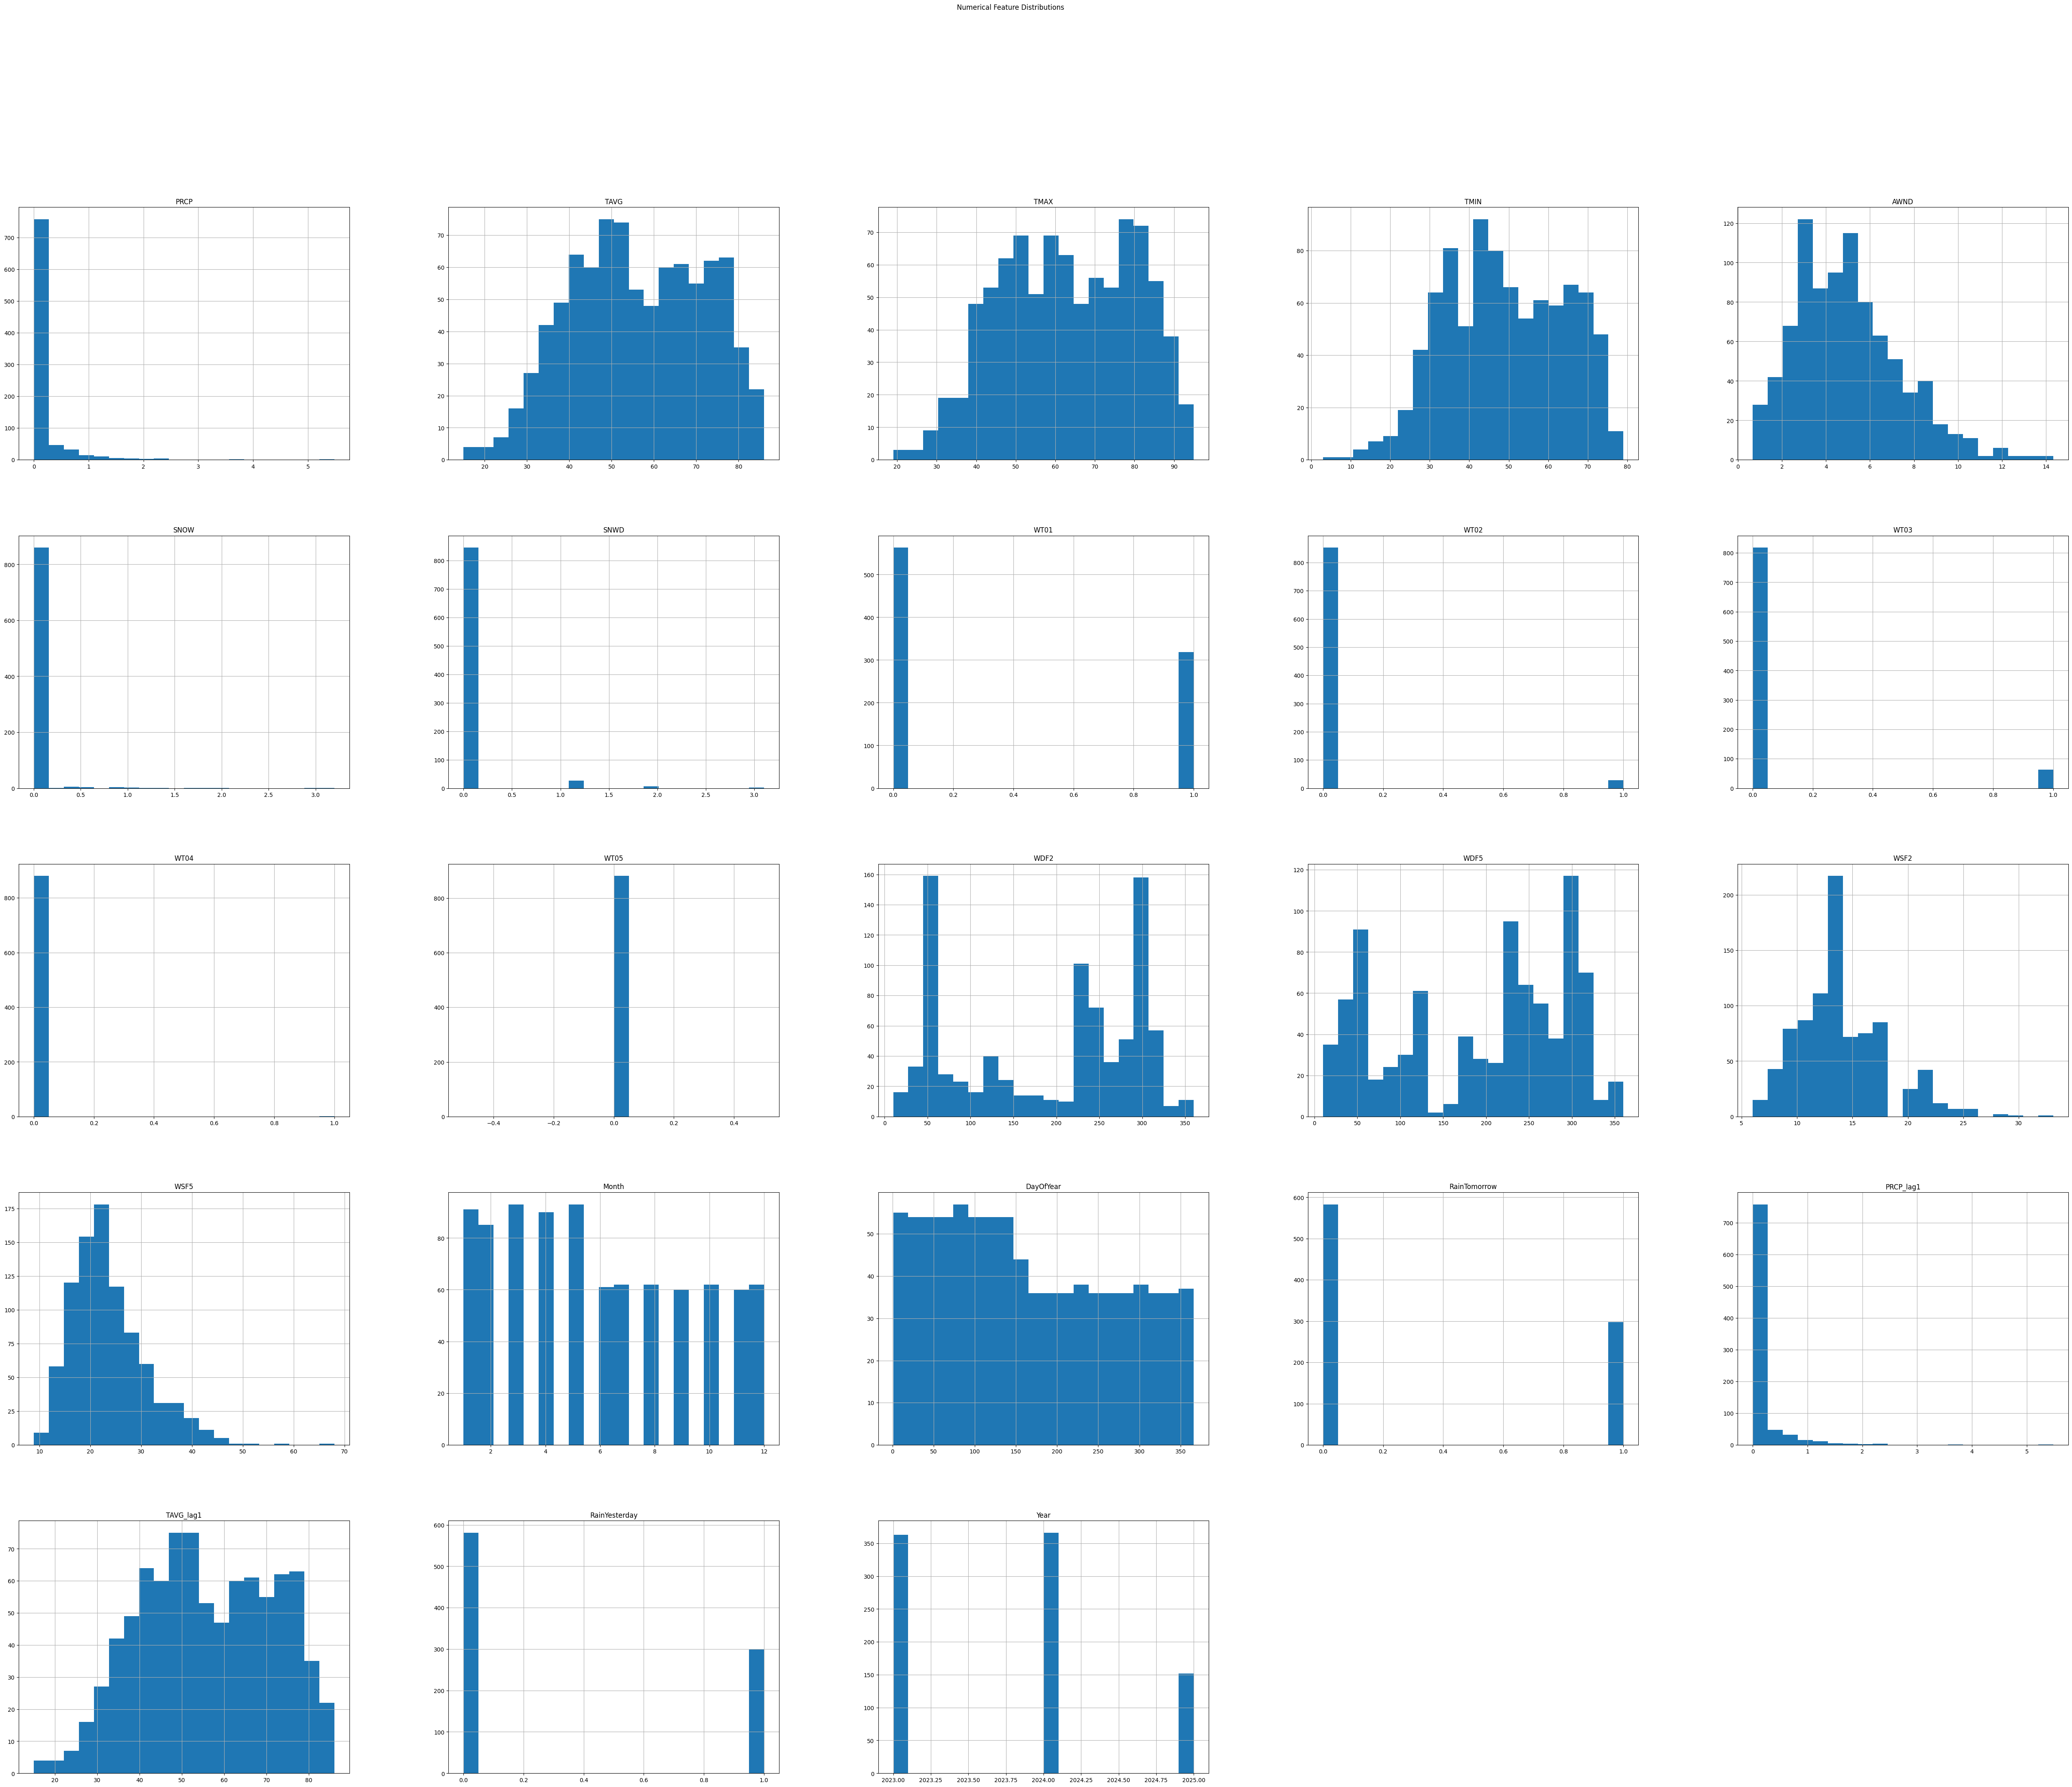

In [27]:
num_cols = df.select_dtypes(include=np.number).columns

df[num_cols].hist(figsize=(65,50), bins=20)
plt.suptitle("Numerical Feature Distributions")
plt.show()


In [28]:
# One-hot encode Season (drop one category to avoid multicollinearity)
df = pd.get_dummies(df, columns=["Season"], drop_first=True)

# Lag features
df["PRCP_lag1"] = df["PRCP"].shift(1)
df["TAVG_lag1"] = df["TAVG"].shift(1)
df = df.dropna(subset=["PRCP_lag1", "TAVG_lag1"]).reset_index(drop=True)

df.head()

,DATE,PRCP,TAVG,TMAX,TMIN,AWND,SNOW,SNWD,WT01,WT02,...,Month,DayOfYear,RainTomorrow,PRCP_lag1,TAVG_lag1,RainYesterday,Year,Season_Spring,Season_Summer,Season_Winter
0,2023-01-04,0.02,57.5,66.0,49.0,4.47,0.0,0.0,1,0,...,1,4,1,0.42,52.5,1,2023,False,False,True
1,2023-01-05,0.01,47.0,50.0,44.0,5.14,0.0,0.0,1,0,...,1,5,1,0.02,57.5,1,2023,False,False,True
2,2023-01-06,0.27,44.0,49.0,39.0,5.37,0.0,0.0,1,0,...,1,6,0,0.01,47.0,1,2023,False,False,True
3,2023-01-07,0.00,41.0,45.0,37.0,6.71,0.0,0.0,0,0,...,1,7,0,0.27,44.0,1,2023,False,False,True
4,2023-01-08,0.00,37.0,41.0,33.0,4.70,0.0,0.0,0,0,...,1,8,1,0.00,41.0,0,2023,False,False,True


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

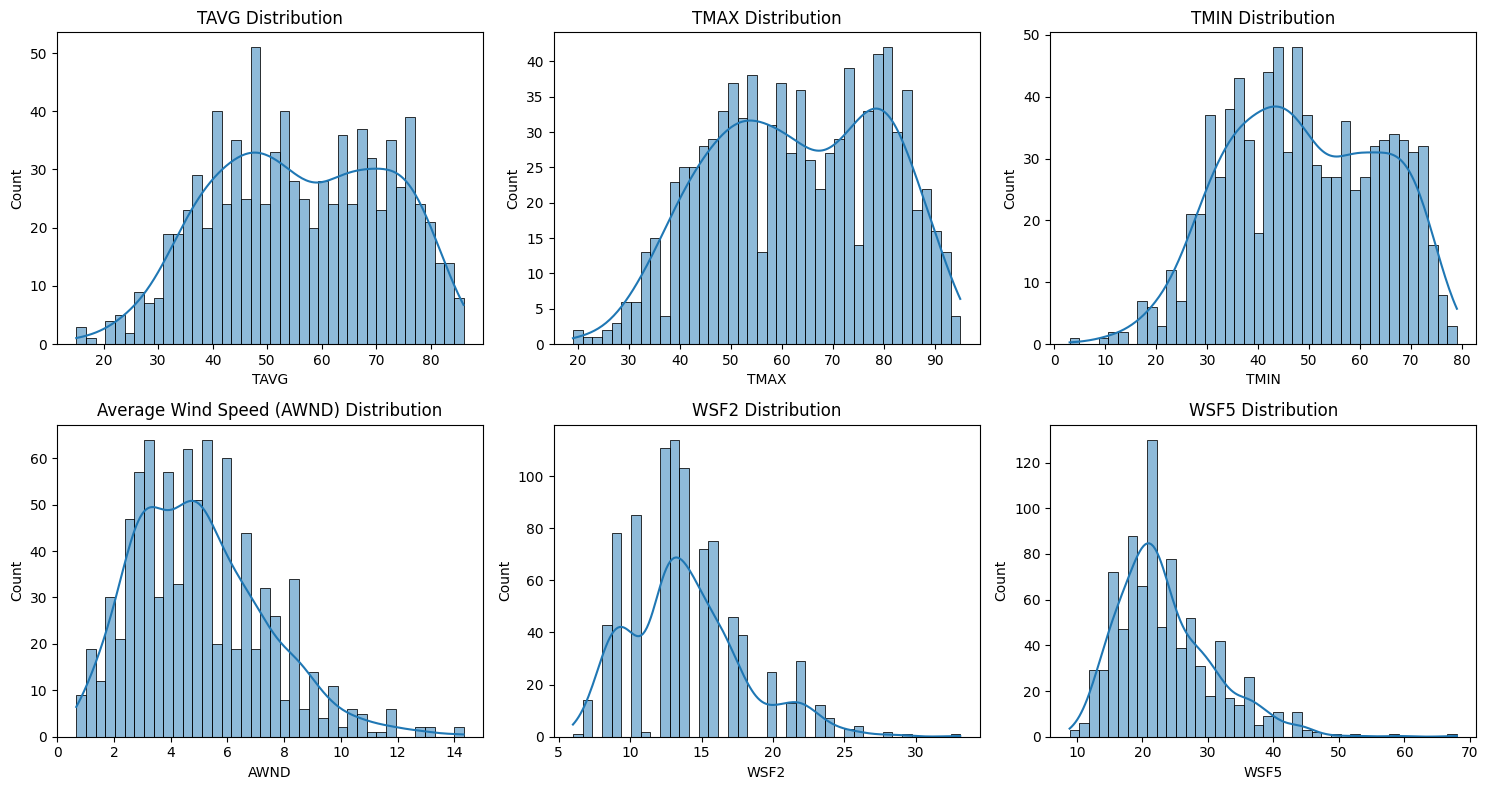

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Temperature distributions
sns.histplot(df["TAVG"], bins=40, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("TAVG Distribution")
axes[0, 0].set_xlabel("TAVG")
axes[0, 0].set_ylabel("Count")

sns.histplot(df["TMAX"], bins=40, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("TMAX Distribution")
axes[0, 1].set_xlabel("TMAX")
axes[0, 1].set_ylabel("Count")

sns.histplot(df["TMIN"], bins=40, kde=True, ax=axes[0, 2])
axes[0, 2].set_title("TMIN Distribution")
axes[0, 2].set_xlabel("TMIN")
axes[0, 2].set_ylabel("Count")

# Wind speed distributions
sns.histplot(df["AWND"], bins=40, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Average Wind Speed (AWND) Distribution")
axes[1, 0].set_xlabel("AWND")
axes[1, 0].set_ylabel("Count")

sns.histplot(df["WSF2"], bins=40, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("WSF2 Distribution")
axes[1, 1].set_xlabel("WSF2")
axes[1, 1].set_ylabel("Count")

sns.histplot(df["WSF5"], bins=40, kde=True, ax=axes[1, 2])
axes[1, 2].set_title("WSF5 Distribution")
axes[1, 2].set_xlabel("WSF5")
axes[1, 2].set_ylabel("Count")

plt.tight_layout()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

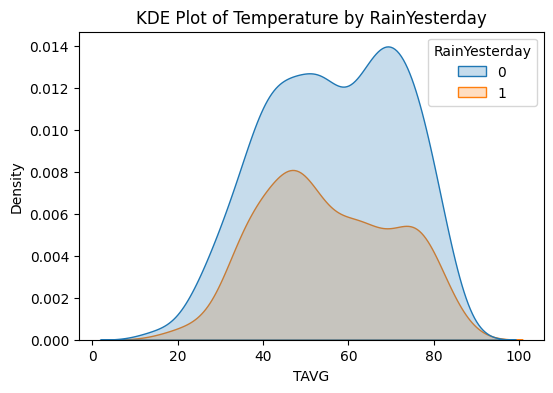

In [31]:
# 7. KDE plot of TAVG by RainToday
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df, x="TAVG", hue="RainYesterday", fill=True)
plt.title("KDE Plot of Temperature by RainYesterday")
plt.xlabel("TAVG")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


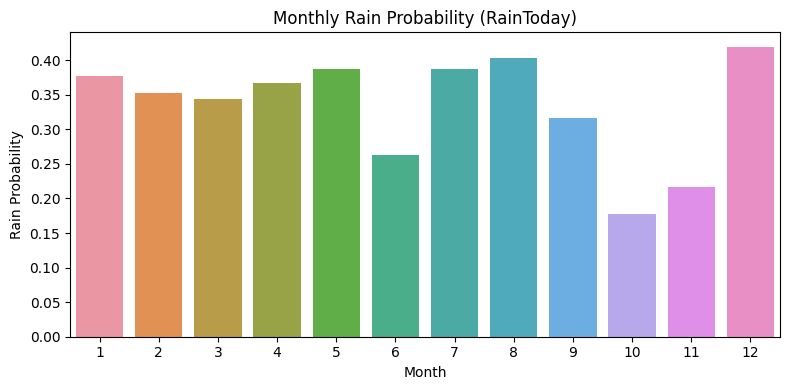

In [34]:
# SECTION 3: Temporal Patterns

# 9. Monthly rain probability (RainToday mean by Month)
monthly_rain = df.groupby("Month")["RainYesterday"].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x="Month", y="RainYesterday", data=monthly_rain)
plt.title("Monthly Rain Probability (RainToday)")
plt.ylabel("Rain Probability")
plt.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

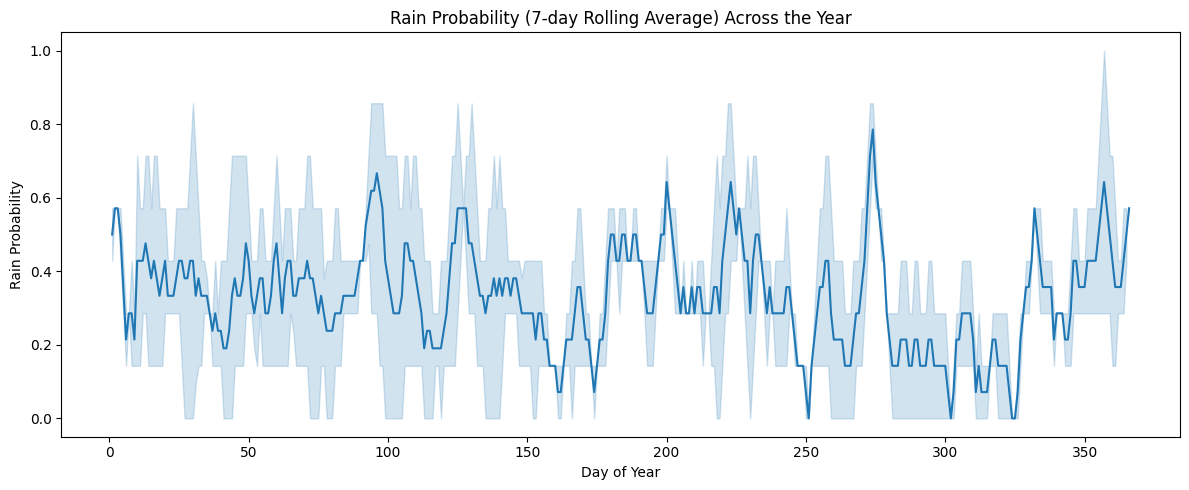

In [35]:
# 10. Rain probability by Day of Year (smoothed line)
df_sorted = df.sort_values("DATE")
# Rolling 7-day average of RainToday
df_sorted["Rain_roll7"] = df_sorted["RainYesterday"].rolling(7).mean()

plt.figure(figsize=(12,5))
sns.lineplot(x="DayOfYear", y="Rain_roll7", data=df_sorted)
plt.title("Rain Probability (7-day Rolling Average) Across the Year")
plt.xlabel("Day of Year")
plt.ylabel("Rain Probability")
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

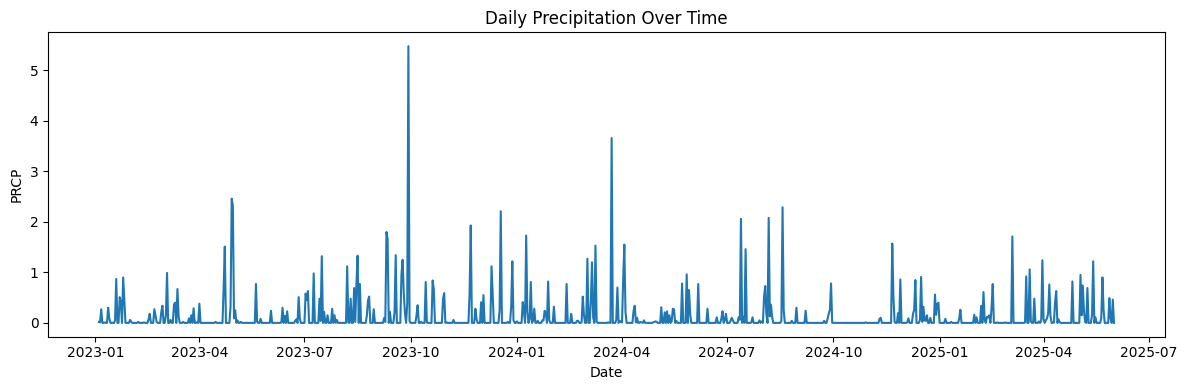

In [36]:
# 12. Time series plot of PRCP over time
plt.figure(figsize=(12, 4))
sns.lineplot(x="DATE", y="PRCP", data=df)
plt.title("Daily Precipitation Over Time")
plt.xlabel("Date")
plt.ylabel("PRCP")
plt.tight_layout()

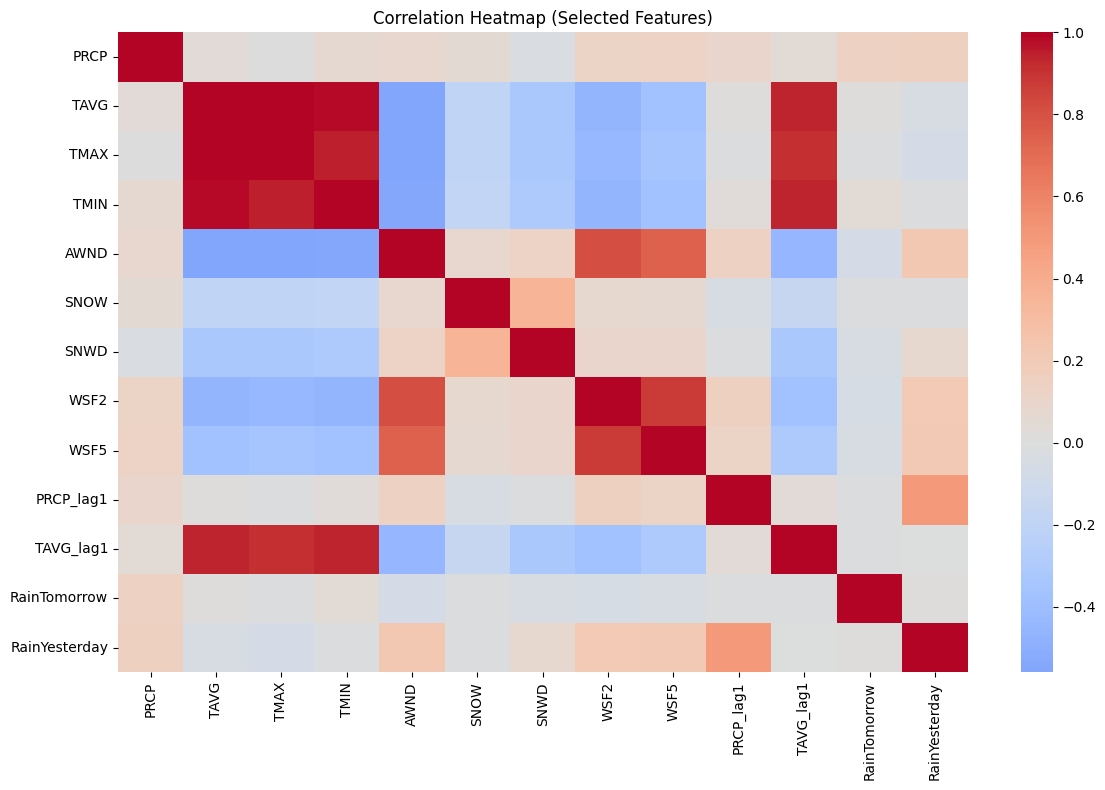

In [37]:
# SECTION 4: Correlation & Lag Features

# 13. Correlation heatmap for selected numeric columns
corr_cols = [
    "PRCP","TAVG","TMAX","TMIN","AWND",
    "SNOW","SNWD","WSF2","WSF5",
    "PRCP_lag1","TAVG_lag1",
    "RainToday","RainTomorrow","RainYesterday"
]
corr_cols = [c for c in corr_cols if c in df.columns]

plt.figure(figsize=(12, 8))
sns.heatmap(df[corr_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Selected Features)")
plt.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


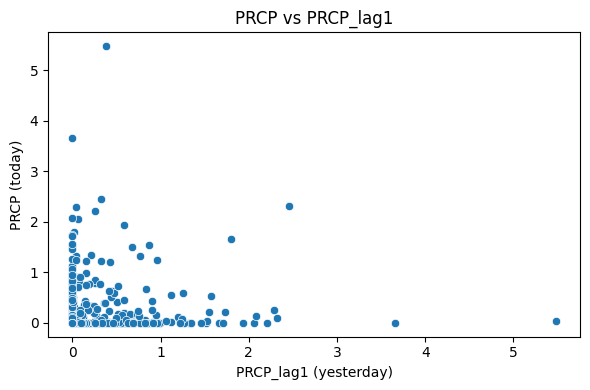

In [38]:
# 14. Scatter plot: PRCP vs PRCP_lag1

plt.figure(figsize=(6, 4))
sns.scatterplot(x="PRCP_lag1", y="PRCP", data=df)
plt.title("PRCP vs PRCP_lag1")
plt.xlabel("PRCP_lag1 (yesterday)")
plt.ylabel("PRCP (today)")
plt.tight_layout()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


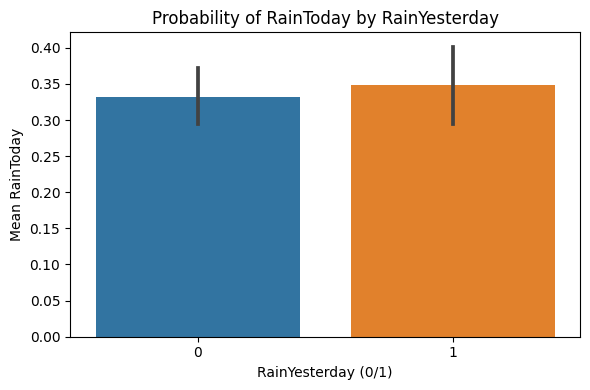

In [40]:
# 15. RainToday vs RainYesterday

plt.figure(figsize=(6, 4))
sns.barplot(x="RainYesterday", y="RainTomorrow", data=df, estimator=np.mean)
plt.title("Probability of RainTomorrow by RainYesterday")
plt.xlabel("RainYesterday (0/1)")
plt.ylabel("Mean RainToday")
plt.tight_layout()

## STEP 4 — Train Models
Train Logistic Regression (L1, L2), Random Forest, Bagging, AdaBoost, Gradient Boosting

## Grid Search for Random Forest
Optimize hyperparameters using 5-fold cross-validation for best performance.

## Evaluate Models Silently
Compute Accuracy, Precision, Recall, F1-score, and AUC without printing or plotting.

## Compile Results
Create a DataFrame with evaluation metrics for all models, sorted by AUC.


In [55]:
# -----------------------------------------------------
# STEP 4 — TRAIN MODELS & EVALUATE THEM SILENTLY
# -----------------------------------------------------

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# -----------------------
# Select Features + Target
# -----------------------
feature_cols = [
    "PRCP", "TAVG", "TMAX", "TMIN", "AWND",
    "SNOW", "SNWD", "WDF2", "WDF5", "WSF2", "WSF5",
    "WT01", "WT02", "WT03", "WT04", "WT05",
    "Month", "DayOfYear",
    "PRCP_lag1", "TAVG_lag1", "RainYesterday"
]

X = df[feature_cols]
y = df["RainTomorrow"]

# -----------------------
# Train/Test Split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)

# -----------------------
# Logistic Regression Models
# -----------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

models = {}

# Standard Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
models["LogisticRegression"] = (log_reg, True)  # True -> scaled

# Logistic Regression L1
log_reg_l1 = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
log_reg_l1.fit(X_train_scaled, y_train)
models["LogisticRegression_L1"] = (log_reg_l1, True)

# Logistic Regression L2
log_reg_l2 = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)
log_reg_l2.fit(X_train_scaled, y_train)
models["LogisticRegression_L2"] = (log_reg_l2, True)

# -----------------------
# Random Forest (no scaling required)
# ------------------------
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
models["RandomForest"] = (rf, False)

# -----------------------
# Bagging Classifier
# ------------------------
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    max_samples=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
bagging_clf.fit(X_train, y_train)
models["Bagging"] = (bagging_clf, False)

# -----------------------
# AdaBoost Classifier
# ------------------------
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
ada_clf.fit(X_train, y_train)
models["AdaBoost"] = (ada_clf, False)

# -----------------------
# Gradient Boosting Classifier
# ------------------------
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_clf.fit(X_train, y_train)
models["GradientBoosting"] = (gb_clf, False)

# -----------------------
# Grid Search for Random Forest
# ------------------------
param_grid_rf = {
    "n_estimators": [200, 300],
    "max_depth": [None, 8, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
models["RandomForest_GridSearch"] = (best_rf, False)

# -----------------------
# SILENT EVALUATION FUNCTION
# ------------------------
def evaluate_model_silent(model, X_test, y_test, scaled=False):
    """Returns metrics dictionary without printing or plotting"""
    X_input = X_test_scaled if scaled else X_test
    y_pred = model.predict(X_input)
    y_prob = model.predict_proba(X_input)[:, 1]

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "auc": roc_auc_score(y_test, y_prob)
    }
    return metrics


results = {}
for name, (model, scaled) in models.items():
    results[name] = evaluate_model_silent(model, X_test, y_test, scaled)




=== Logistic Regression ===
Accuracy:  0.6591
Precision: 0.5500
Recall:    0.1429
F1-score:  0.2268
AUC:       0.6038


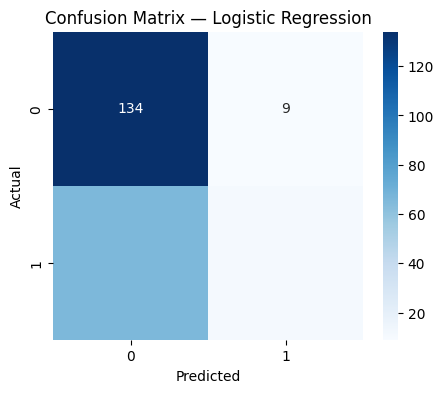

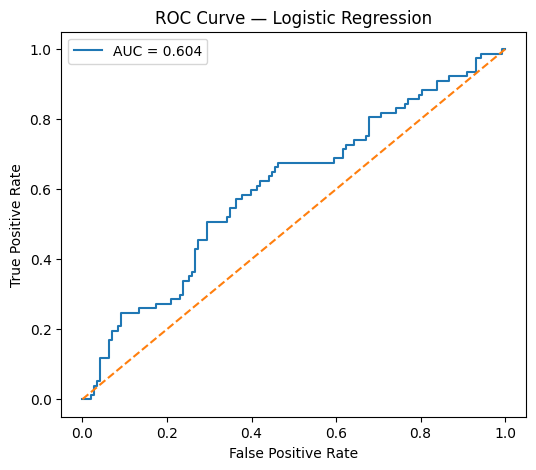


=== L1 Logistic (LASSO) ===
Accuracy:  0.6545
Precision: 0.5263
Recall:    0.1299
F1-score:  0.2083
AUC:       0.6033


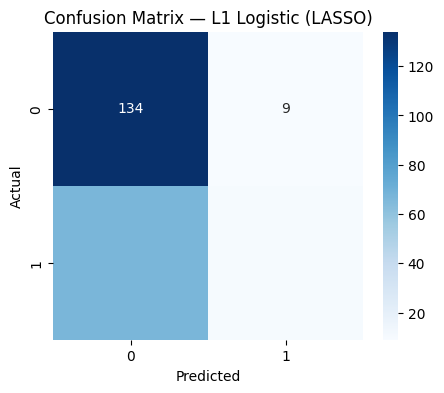

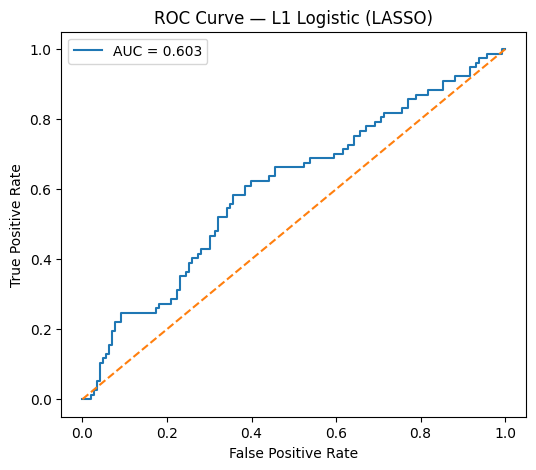


=== L2 Logistic (Ridge) ===
Accuracy:  0.6591
Precision: 0.5500
Recall:    0.1429
F1-score:  0.2268
AUC:       0.6038


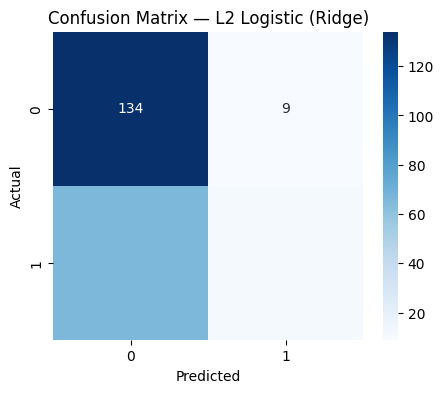

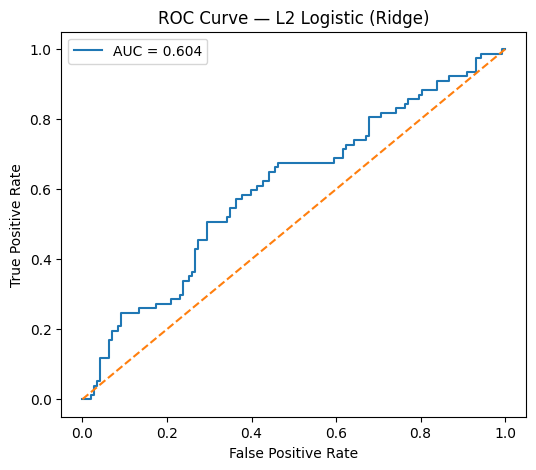


=== Random Forest ===
Accuracy:  0.6045
Precision: 0.3684
Recall:    0.1818
F1-score:  0.2435
AUC:       0.5617


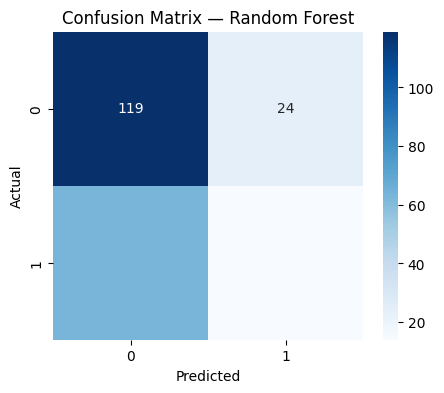

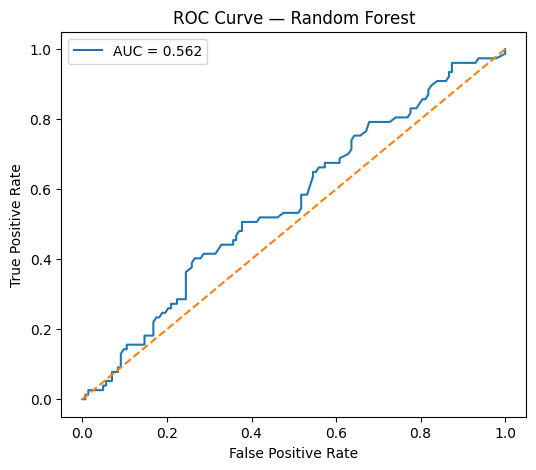


=== Bagging (Decision Trees) ===
Accuracy:  0.6500
Precision: 0.5000
Recall:    0.2468
F1-score:  0.3304
AUC:       0.5902


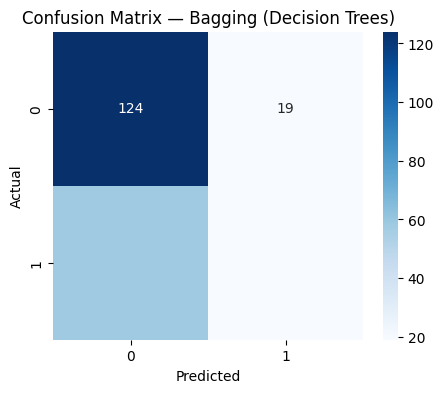

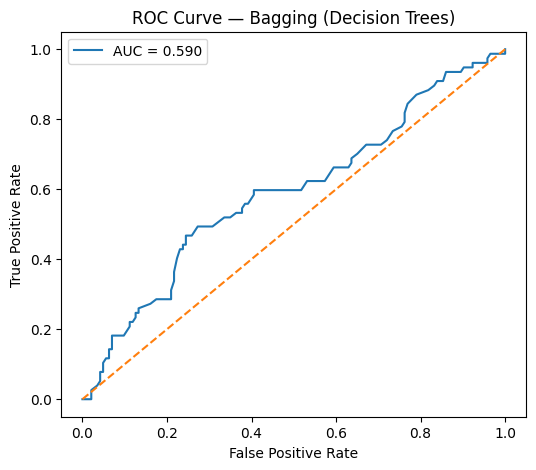


=== AdaBoost ===
Accuracy:  0.6273
Precision: 0.4324
Recall:    0.2078
F1-score:  0.2807
AUC:       0.5928


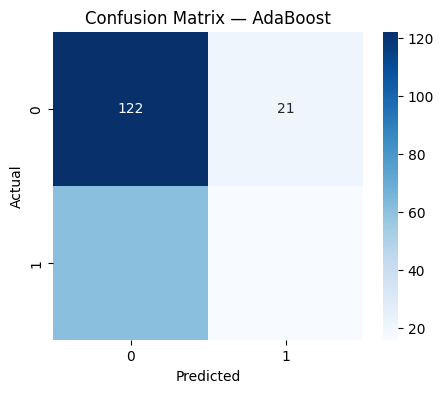

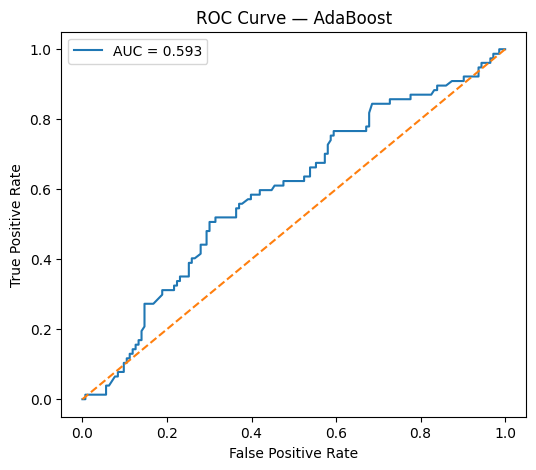


=== Gradient Boosting ===
Accuracy:  0.6182
Precision: 0.4364
Recall:    0.3117
F1-score:  0.3636
AUC:       0.5940


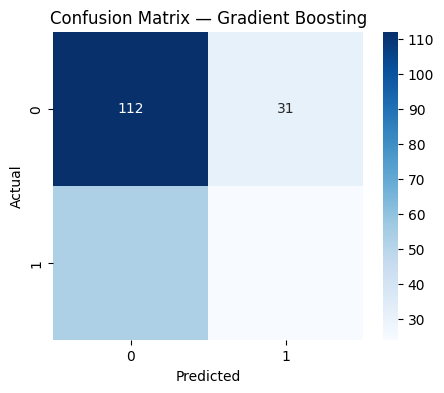

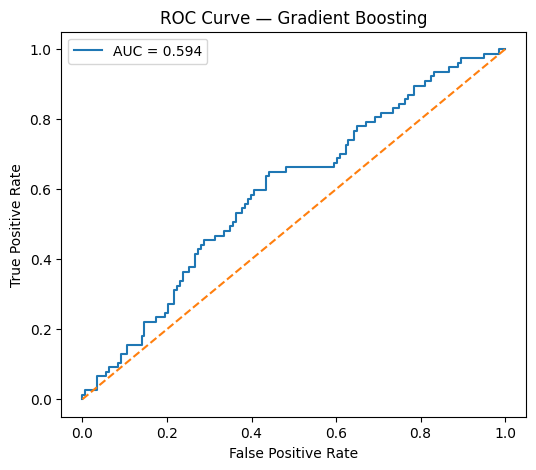


=== Random Forest (GridSearch) ===
Accuracy:  0.6409
Precision: 0.4545
Recall:    0.1299
F1-score:  0.2020
AUC:       0.6104


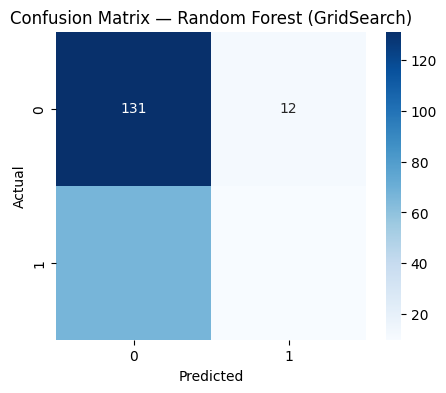

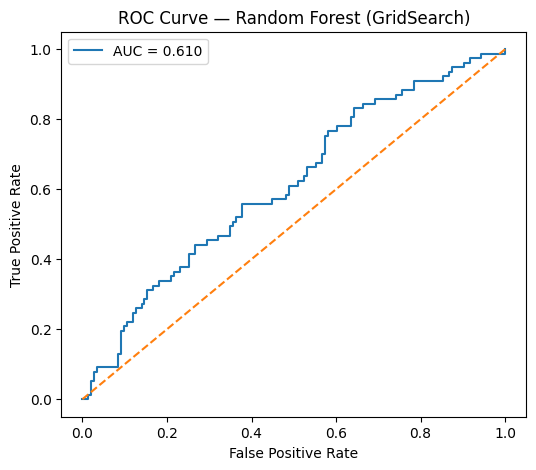

In [56]:
results = []

results.append(["Logistic Regression"] +
               list(evaluate_model(log_reg, X_test, y_test,
                                   "Logistic Regression", scaled=True)))

results.append(["L1 Logistic (LASSO)"] +
               list(evaluate_model(log_reg_l1, X_test, y_test,
                                   "L1 Logistic (LASSO)", scaled=True)))

results.append(["L2 Logistic (Ridge)"] +
               list(evaluate_model(log_reg_l2, X_test, y_test,
                                   "L2 Logistic (Ridge)", scaled=True)))

results.append(["Random Forest"] +
               list(evaluate_model(rf, X_test, y_test,
                                   "Random Forest", scaled=False)))
# -----------------------
# Ensemble Models Results
# -----------------------

results.append(["Bagging (Decision Trees)"] +
               list(evaluate_model(bagging_clf, X_test, y_test,
                                   "Bagging (Decision Trees)", scaled=False)))

results.append(["AdaBoost"] +
               list(evaluate_model(ada_clf, X_test, y_test,
                                   "AdaBoost", scaled=False)))

results.append(["Gradient Boosting"] +
               list(evaluate_model(gb_clf, X_test, y_test,
                                   "Gradient Boosting", scaled=False)))

results.append(["Random Forest (GridSearch)"] +
               list(evaluate_model(best_rf, X_test, y_test,
                                   "Random Forest (GridSearch)", scaled=False)))



In [57]:
results_df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"]
)

results_df.sort_values("AUC", ascending=False)


,Model,Accuracy,Precision,Recall,F1-score,AUC
7,Random Forest (GridSearch),0.640909,0.454545,0.129870,0.202020,0.610390
0,Logistic Regression,0.659091,0.550000,0.142857,0.226804,0.603760
2,L2 Logistic (Ridge),0.659091,0.550000,0.142857,0.226804,0.603760
1,L1 Logistic (LASSO),0.654545,0.526316,0.129870,0.208333,0.603306
6,Gradient Boosting,0.618182,0.436364,0.311688,0.363636,0.594042
5,AdaBoost,0.627273,0.432432,0.207792,0.280702,0.592771
4,Bagging (Decision Trees),0.650000,0.500000,0.246753,0.330435,0.590228
3,Random Forest,0.604545,0.368421,0.181818,0.243478,0.561666


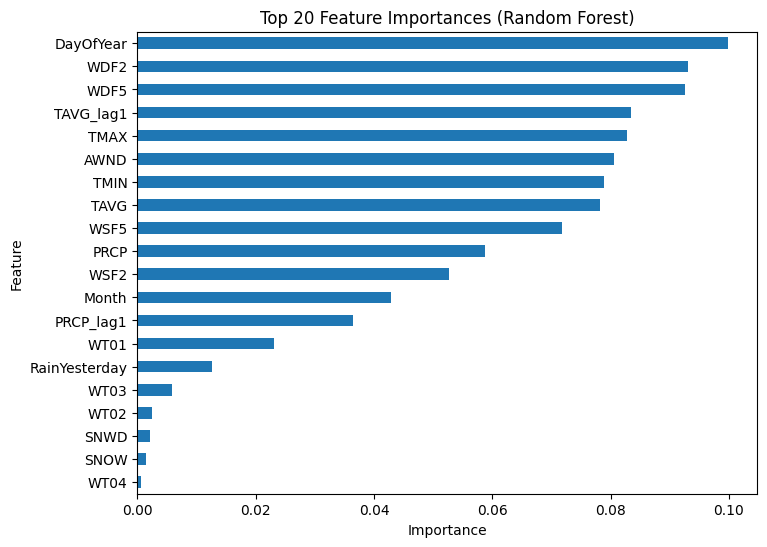

DayOfYear        0.099799
WDF2             0.092998
WDF5             0.092536
TAVG_lag1        0.083520
TMAX             0.082718
AWND             0.080597
TMIN             0.078888
TAVG             0.078214
WSF5             0.071838
PRCP             0.058686
WSF2             0.052680
Month            0.042830
PRCP_lag1        0.036526
WT01             0.023045
RainYesterday    0.012588
WT03             0.005863
WT02             0.002515
SNWD             0.002170
SNOW             0.001432
WT04             0.000557
dtype: float64

In [58]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)

plt.figure(figsize=(8,6))
importances.sort_values().tail(20).plot(kind="barh")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

importances.sort_values(ascending=False).head(20)
